# ICS 438 Project: Fake News
## by: Leilani Reich

### Link to Dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=True.csv

### GitHub Repo: https://github.com/leilani-reich/ICS438-FinalProject-FakeNews

## Install Libraries

In [ ]:
#!pip install pyspark
#!python -m pip install -U gensim
#%pip install -U sentence-transformers
#!pip install --user annoy
#!pip install faiss-cpu --no-cache
!pip install autofaiss

In [1]:
# Create new Spark Context
from pyspark import SparkContext
sc = SparkContext()

In [2]:
# Create new Spark Session
from pyspark.sql import SparkSession
session = SparkSession(sc)

### Load in Data

In [3]:
# Some of the data like the text contains double quotes, which really cause a lot of issues!
# So I need escape='"'
fake_df = session.read.csv("Fake.csv", inferSchema = True, header=True, multiLine=True, escape='"')

print(type(fake_df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [4]:
fake_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



In [5]:
true_df = session.read.csv("True.csv", inferSchema = True, header=True, multiLine=True, escape='"')

print(type(true_df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [6]:
true_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



## Preprocess Data

In [7]:
# Remove missing info

fake_df = fake_df.dropna()
true_df = true_df.dropna()


fake news types ['US_News', 'left-news', 'politics', 'Government News', 'Middle-east', 'News']
fake news types counts: [783, 4459, 6841, 1570, 778, 9050]
+---------------+-----+
|        subject|count|
+---------------+-----+
|        US_News|  783|
|      left-news| 4459|
|       politics| 6841|
|Government News| 1570|
|    Middle-east|  778|
|           News| 9050|
+---------------+-----+



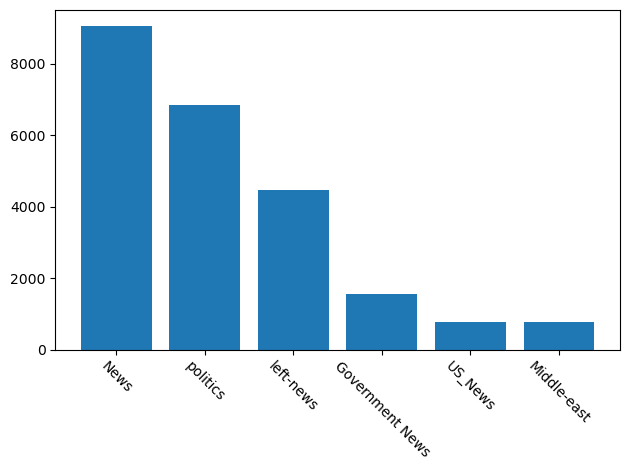

In [8]:
import matplotlib.pyplot as plt

# Visualize the types of fake news by frequency

# Get the unique subject names for the articles
fake_news_types = fake_df.select("subject").distinct()
fake_news_types = list(fake_news_types.toPandas()["subject"])
print("fake news types", fake_news_types)

# Get the total counts for each type of article
fake_news_types_counts = fake_df.groupBy("subject").count().select("count")
fake_news_types_counts = list(fake_news_types_counts.toPandas()["count"])
print("fake news types counts:", fake_news_types_counts)

# Show subject names and corresponding counts in table
fake_df.groupBy("subject").count().show()

# Create dictionary with subjects as keys and counts as values
fake_news_dict = dict(zip(fake_news_types, fake_news_types_counts))

# Sort in ascending order by value
fake_news_by_frequency = sorted(fake_news_dict.items(), key=lambda x: x[1], reverse=True)

# Get sorted keys and values
fn_subjects, fn_counts = zip(*fake_news_by_frequency)

# Show subject names and corresponding counts in barchart
plt.bar(x = fn_subjects, height = fn_counts)

plt.xticks(rotation=-45)

plt.tight_layout()

plt.show()

true news types ['worldnews', 'politicsNews']
true news types counts: [10145, 11272]
+------------+-----+
|     subject|count|
+------------+-----+
|   worldnews|10145|
|politicsNews|11272|
+------------+-----+



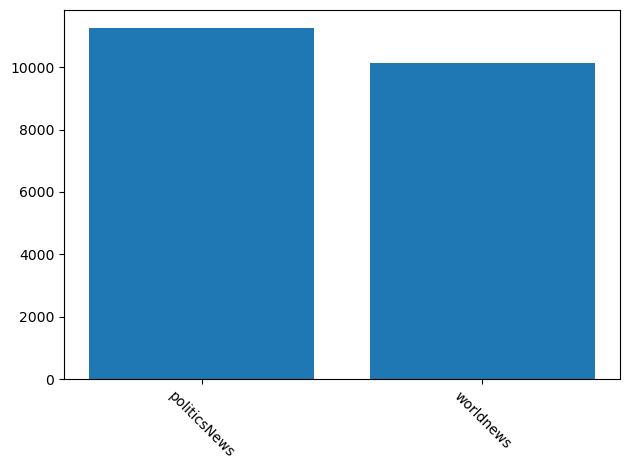

In [9]:
# Visualize the types of true news by frequency

# Get the unique subject names for the articles
true_news_types = true_df.select("subject").distinct()
true_news_types = list(true_news_types.toPandas()["subject"])
print("true news types", true_news_types)

# Get the total counts for each type of article
true_news_types_counts = true_df.groupBy("subject").count().select("count")
true_news_types_counts = list(true_news_types_counts.toPandas()["count"])
print("true news types counts:", true_news_types_counts)

# Show subject names and corresponding counts in table
true_df.groupBy("subject").count().show()

# Create dictionary with subjects as keys and counts as values
true_news_dict = dict(zip(true_news_types, true_news_types_counts))

# Sort in ascending order by value
true_news_by_frequency = sorted(true_news_dict.items(), key=lambda x: x[1], reverse=True)

# Get sorted keys and values
fn_subjects, fn_counts = zip(*true_news_by_frequency)

# Show subject names and corresponding counts in barchart
plt.bar(x = fn_subjects, height = fn_counts)

plt.xticks(rotation=-45)

plt.tight_layout()


+-----------------+-----+
|             date|count|
+-----------------+-----+
|     May 30, 2017|   27|
|    March 2, 2017|   24|
|   April 29, 2016|   20|
|   March 25, 2016|   28|
|      Oct 4, 2017|   13|
|      Oct 8, 2016|   20|
|     Sep 27, 2015|   12|
|      Jun 4, 2015|    9|
|February 25, 2016|   25|
|      Nov 1, 2017|   17|
|      Oct 9, 2017|    7|
|     Sep 14, 2016|   15|
|      Aug 9, 2015|    8|
|     Feb 10, 2016|   14|
|December 22, 2017|    1|
|    July 18, 2017|    4|
|    June 27, 2017|   10|
|     May 25, 2017|   26|
|    March 7, 2017|   22|
| December 7, 2016|   21|
+-----------------+-----+
only showing top 20 rows

Top 10 most prevalent dates of fake news posts [('May 30, 2017', 27), ('March 2, 2017', 24), ('April 29, 2016', 20), ('March 25, 2016', 28), ('Oct 4, 2017', 13), ('Oct 8, 2016', 20), ('Sep 27, 2015', 12), ('Jun 4, 2015', 9), ('February 25, 2016', 25), ('Nov 1, 2017', 17)]


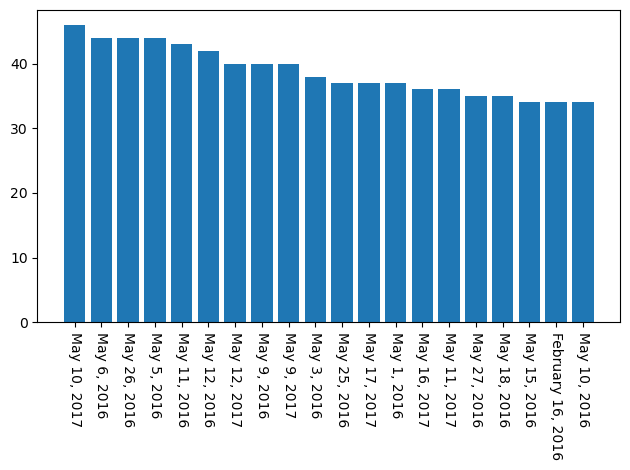

In [10]:
# Visualizing the top 20 most prominent dates of fake news

# Get the unique dates for the articles
fake_news_dates = fake_df.select("date").distinct()
fake_news_dates = list(fake_news_dates.toPandas()["date"])
#print("fake news dates", fake_news_dates)

# Get the total counts for each type of article
fake_news_dates_counts = fake_df.groupBy("date").count().select("count")
fake_news_dates_counts = list(fake_news_dates_counts.toPandas()["count"])
#print("fake news dates counts:", fake_news_dates_counts)

# Show dates and corresponding counts in table
fake_df.groupBy("date").count().show()

# Create dictionary with subjects as keys and counts as values
fake_news_dict = dict(zip(fake_news_dates, fake_news_dates_counts))

# Sort in ascending order by value
fake_news_dates_by_frequency = sorted(fake_news_dict.items(), key=lambda x: x[1], reverse=True)

print("Top 10 most prevalent dates of fake news posts", list(fake_news_dict.items())[:10])

# Get sorted keys and values
fn_dates, fn_counts = zip(*fake_news_dates_by_frequency)

# Show subject names and corresponding counts in barchart
plt.bar(x = fn_dates[:20], height = fn_counts[:20])

plt.xticks(rotation=-90)

plt.tight_layout()

plt.show()

+------------------+-----+
|              date|count|
+------------------+-----+
|     May 18, 2017 |   34|
|   March 15, 2017 |   30|
|  August 29, 2016 |   18|
|  August 24, 2016 |   11|
|     July 7, 2016 |   13|
|      May 2, 2016 |    9|
| October 29, 2017 |   47|
|    June 24, 2017 |    1|
|   April 12, 2017 |   31|
|  August 10, 2016 |    8|
|      May 3, 2016 |    9|
|    April 4, 2016 |   14|
|    July 27, 2017 |   36|
|    June 26, 2017 |   22|
|      May 4, 2017 |   22|
|   April 30, 2017 |    6|
|September 2, 2017 |   36|
| December 4, 2016 |   12|
|November 20, 2016 |   16|
| October 18, 2016 |   18|
+------------------+-----+
only showing top 20 rows

Top 10 most prevalent dates of true news posts [('May 18, 2017 ', 34), ('March 15, 2017 ', 30), ('August 29, 2016 ', 18), ('August 24, 2016 ', 11), ('July 7, 2016 ', 13), ('May 2, 2016 ', 9), ('October 29, 2017 ', 47), ('June 24, 2017 ', 1), ('April 12, 2017 ', 31), ('August 10, 2016 ', 8)]


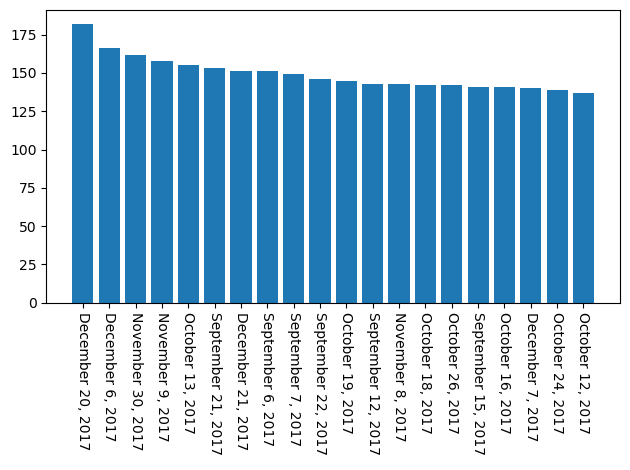

In [11]:
# Visualizing the top 20 most prominent dates of true news

# Get the unique dates for the articles
true_news_dates = true_df.select("date").distinct()
true_news_dates = list(true_news_dates.toPandas()["date"])
#print("true news dates", true_news_dates)

# Get the total counts for each type of article
true_news_dates_counts = true_df.groupBy("date").count().select("count")
true_news_dates_counts = list(true_news_dates_counts.toPandas()["count"])
#print("true news dates counts:", true_news_dates_counts)

# Show dates and corresponding counts in table
true_df.groupBy("date").count().show()

# Create dictionary with subjects as keys and counts as values
true_news_dict = dict(zip(true_news_dates, true_news_dates_counts))

# Sort in ascending order by value
true_news_dates_by_frequency = sorted(true_news_dict.items(), key=lambda x: x[1], reverse=True)

print("Top 10 most prevalent dates of true news posts", list(true_news_dict.items())[:10])

# Get sorted keys and values
fn_dates, fn_counts = zip(*true_news_dates_by_frequency)

# Show subject names and corresponding counts in barchart
plt.bar(x = fn_dates[:20], height = fn_counts[:20])

plt.xticks(rotation=-90)

plt.tight_layout()

plt.show()

## Lengths of fake vs real news
- Assumption: fake news is longer

Fake news title average length: 94.19769175077722
True news title average length: 64.667880655554


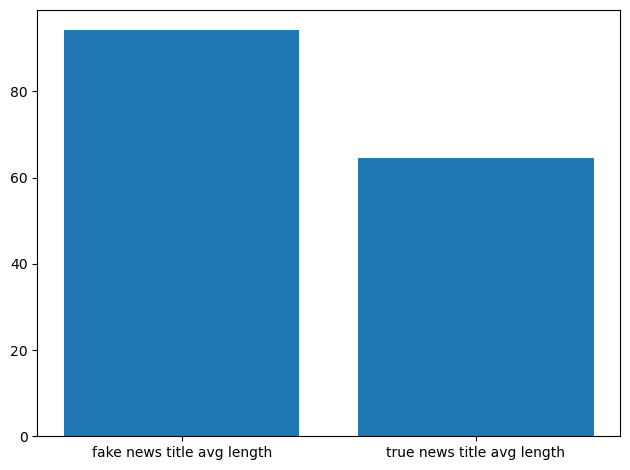

In [26]:
# Comparing lengths of title of posts for fake and true news
import pyspark.sql.functions as F

# Fake news average title length
fake_news_length = fake_df.withColumn("title_length", F.length(fake_df.title))
fake_news_title_avg = fake_news_length.agg(F.avg(F.col("title_length"))).first()[0]

# True news average title length
true_news_length = true_df.withColumn("title_length", F.length(true_df.title))
true_news_title_avg = true_news_length.agg(F.avg(F.col("title_length"))).first()[0]

print("Fake news title average length:", fake_news_title_avg)
print("True news title average length:", true_news_title_avg)

# Show subject names and corresponding counts in barchart
plt.bar(x = ["fake news title avg length", "true news title avg length"], height = [fake_news_title_avg, true_news_title_avg])

plt.xticks(rotation=0)

plt.tight_layout()

plt.show()

Fake news text average length: 2547.396235254035
True news text average length: 2383.278517065882


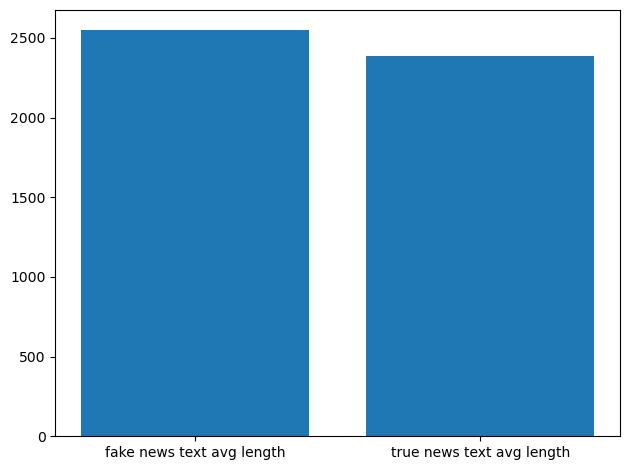

In [27]:
# Comparing lengths of text of posts for fake and true news

# Fake news average text length
fake_news_length = fake_df.withColumn("text_length", F.length(fake_df.text))
fake_news_text_avg = fake_news_length.agg(F.avg(F.col("text_length"))).first()[0]

# True news average title length
true_news_length = true_df.withColumn("text_length", F.length(true_df.text))
true_news_text_avg = true_news_length.agg(F.avg(F.col("text_length"))).first()[0]

print("Fake news text average length:", fake_news_text_avg)
print("True news text average length:", true_news_text_avg)

# Show subject names and corresponding counts in barchart
plt.bar(x = ["fake news text avg length", "true news text avg length"], height = [fake_news_text_avg, true_news_text_avg])

plt.xticks(rotation=0)

plt.tight_layout()

plt.show()

## Preparing Text Data

In [28]:
# Preprocess the text data
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_short

# Do some common cleaning options to remove noise from text
def clean_text(text):
    text_p1 = remove_stopwords(text)
    text_p2 = strip_punctuation(text_p1)
    text_p3 = strip_short(text_p2)
    return text_p3.lower()
    
    # How to remove @ from text?


In [29]:
# I combined the title and text and am considering them together
fake_text = fake_df.rdd.map(lambda x: clean_text(x["title"]+ " " + x["text"]))

print(type(fake_text))

print(fake_text.first())

<class 'pyspark.rdd.PipelinedRDD'>
donald trump sends out embarrassing new year’s eve message this disturbing donald trump couldn wish americans happy new year leave that instead shout enemies haters dishonest fake news media the reality star job couldn country rapidly grows stronger smarter want wish friends supporters enemies haters dishonest fake news media happy healthy new year president angry pants tweeted 2018 great year america country rapidly grows stronger smarter want wish friends supporters enemies haters dishonest fake news media happy healthy new year 2018 great year america donald trump realdonaldtrump december 2017trump tweet went welll expect what kind president sends new year greeting like despicable petty infantile gibberish only trump his lack decency won allow rise gutter long wish american citizens happy new year bishop talbert swan talbertswan december 2017no likes calvin calvinstowell december 2017your impeachment 2018 great year america accept regaining control

In [30]:
# I combined the title and text and am considering them together
true_text = true_df.rdd.map(lambda x: clean_text(x["title"]+ " " + x["text"]))

print(type(true_text))

print(true_text.first())

<class 'pyspark.rdd.PipelinedRDD'>
budget fight looms republicans flip fiscal script washington reuters the head conservative republican faction congress voted month huge expansion national debt pay tax cuts called “fiscal conservative” sunday urged budget restraint 2018 keeping sharp pivot way republicans representative mark meadows speaking cbs’ “face nation drew hard line federal spending lawmakers bracing battle january when return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want big budget increase military spending democrats want proportional increases non defense “discretionary” spending programs support education scientific research infrastructure public health environmental protection “the trump administration willing say ‘we’re going increase non defense discretionary spending percent meadows ch

## Get words with highest tf-idfs for types of news

In [34]:
# Load in news text as spark dataframes and add column for the type of news (fake or true)
from pyspark.sql.functions import lit
from pyspark.sql import Row

fake_text_df = fake_text.map(Row("value")).toDF()
# adding new column for class_name, which is all "fake"
fake_text_df = fake_text_df.withColumn("class_name", lit("fake"))

true_text_df = true_text.map(Row("value")).toDF()
# adding new column for class_name, which is all "true"
true_text_df = true_text_df.withColumn("class_name", lit("true"))

print(fake_text_df.columns)
print(true_text_df.columns)

['value', 'class_name']
['value', 'class_name']


In [35]:
# Combine the dataframes into one
import pyspark.sql.functions as F

news_text_df = fake_text_df.union(true_text_df)
# make the order of fake/true news random
news_text_df = news_text_df.select("*").orderBy(F.rand())

news_text_df.show()

+--------------------+----------+
|               value|class_name|
+--------------------+----------+
|republican rand p...|      true|
|breaking bad news...|      fake|
|just trump gives ...|      fake|
|breaking obama ap...|      fake|
|even white nation...|      fake|
|new york times pu...|      fake|
|china partly lift...|      true|
|trump pro oil age...|      true|
|illinois governor...|      true|
|london mayor says...|      true|
|wow former attorn...|      fake|
|president trump p...|      fake|
|german court rule...|      true|
|long way german c...|      true|
|top mexico univer...|      true|
|obama’s america i...|      fake|
|breitbart racist ...|      fake|
|more germans deta...|      true|
|why trump’s own c...|      fake|
|paul lepage claim...|      fake|
+--------------------+----------+
only showing top 20 rows



In [ ]:
# Let's get the tf-idf to see the most common words
# https://spark.apache.org/docs/latest/mllib-feature-extraction.html

from pyspark.ml.feature import HashingTF, IDF, Tokenizer

# Start by tokenizing text
tokenizer = Tokenizer(inputCol="value", outputCol="tokens")
news_text_tokenized = tokenizer.transform(news_text_df)

news_text_tokenized.show()


In [ ]:
# Computing the tf-idf

hashingTF = HashingTF(inputCol="tokens", outputCol="raw_features")
tf = hashingTF.transform(news_text_tokenized)

tf.cache()
idf = IDF(inputCol="raw_features", outputCol="features").fit(tf)
tfidf = idf.transform(tf)

tfidf.select(["class_name", "tokens", "features"]).show()


In [ ]:
# What does the data look like?

print(type(tfidf.select("features").first()))

print(tfidf.select("features").first())

In [ ]:
# Get most important words according to tf-idf

from pyspark.sql.types import ArrayType, DoubleType, StringType, MapType

# I used code from stackoverflow and applied it to my data:
# source - https://stackoverflow.com/questions/69218494/pyspark-display-top-10-words-of-document

ndf = tfidf.select('class_name',F.explode('tokens').name('exptokens')).withColumn('tokens',F.array('exptokens'))
hashudf = F.udf(lambda vector : vector.indices.tolist()[0],StringType())
wordtf = hashingTF.transform(ndf).withColumn('wordhash',hashudf(F.col('raw_features')))
wordtf.show()

In [ ]:
# I used code from stackoverflow and applied it to my data:
# source - https://stackoverflow.com/questions/69218494/pyspark-display-top-10-words-of-document# 

udf1 = F.udf(lambda vec : dict(zip(vec.indices.tolist(),vec.values.tolist())),MapType(StringType(),StringType()))
valuedf = tfidf.select('class_name',F.explode(udf1(F.col('features'))).name('wordhash','value'))
valuedf.show()

In [ ]:
from pyspark.sql import Window

# I used code from stackoverflow and applied it to my data:
# source - https://stackoverflow.com/questions/69218494/pyspark-display-top-10-words-of-document# 

w = Window.partitionBy("class_name").orderBy(F.desc('value'))
valuedf = valuedf.withColumn('rank',F.rank().over(w)).where(F.col('rank')<=3) # used 3 for testing.
topn_df = valuedf.join(wordtf,['class_name','wordhash']).groupby('class_name').agg(F.sort_array(F.collect_list(F.struct(F.col('value'),F.col('exptokens'))),asc=False).name('topn'))

topn_df.show()

In [ ]:
#print(topn_df.first()[1])

# Dungeons, descent, macy are top words for fake news??

## Split Data

In [36]:
import numpy as np

# Setting up for embedding for news text:

# Splitting data into train and test
news_text_train_df, news_text_test_df = news_text_df.randomSplit([0.9, 0.1])

# Double check randomsplit gives what we expect
news_train_len = news_text_train_df.count()
news_test_len = news_text_test_df.count()
total_len = news_train_len + news_test_len

print("Percent training:", round(news_train_len / total_len, 2))
print("Percent testing:", round(news_test_len / total_len, 2))


Percent training: 0.9
Percent testing: 0.1


## Can we classify news as being fake or true?

- use classes of sentences closest to query to assign class to query
- and what sentences are closest to query?

In [95]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, NGram, BucketedRandomProjectionLSH

# Create a pipeline
model = Pipeline(stages=[
    # Create tokens from words
    Tokenizer(inputCol="value", outputCol="tokens"),
    # Get ngrams from tokens (speeds up computation)
    NGram(n=8, inputCol="tokens", outputCol="ngrams"),
    # Get feature vectors to input to LSH
    HashingTF(inputCol="ngrams", outputCol="vectors"),
]).fit(news_text_train_df)

news_text_trans = model.transform(news_text_train_df)

In [96]:
# Create LSH model Bucket Random Projection (https://spark.apache.org/docs/2.2.3/ml-features.html#lsh-operations)
LSH_model = BucketedRandomProjectionLSH(inputCol="vectors", outputCol="lsh", bucketLength=2.0, numHashTables=3).fit(news_text_trans)

LSH_model.transform(news_text_trans).show()

+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|               value|class_name|              tokens|              ngrams|             vectors|                 lsh|
+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|000 free for all ...|      fake|[000, free, for, ...|[000 free for all...|(262144,[105,2303...|[[-1.0], [-1.0], ...|
|000 free for all ...|      fake|[000, free, for, ...|[000 free for all...|(262144,[105,2303...|[[-1.0], [-1.0], ...|
|100 fed with hill...|      fake|[100, fed, with, ...|[100 fed with hil...|(262144,[4732,686...|[[0.0], [-1.0], [...|
|100 fed with hill...|      fake|[100, fed, with, ...|[100 fed with hil...|(262144,[4732,686...|[[0.0], [-1.0], [...|
|100 fed with hill...|      fake|[100, fed, with, ...|[100 fed with hil...|(262144,[4732,686...|[[0.0], [-1.0], [...|
|110k stolen from ...|      fake|[110k, stolen, fr...|[1

In [97]:
# Double check what columns were for test set
print(news_text_test_df.columns)

['value', 'class_name']


In [111]:
keys = model.transform(news_text_test_df)

print(type(keys.first()[4]))
print(keys.columns)

<class 'pyspark.ml.linalg.SparseVector'>
['value', 'class_name', 'tokens', 'ngrams', 'vectors']


In [107]:
#key = model.transform(news_text_test_df.first()[0])

result = LSH_model.approxNearestNeighbors(news_text_trans, keys.first()[4], 5)


In [112]:
# Get counts of how many neighbors were from the fake news class and the true news class
class_name_counts = result.groupBy("class_name").count()

# First index of keys.first() is class_name
print("Real class:", keys.first()[1])
# Get class with max count from neighbors
print("Predicted class:", class_name_counts.first()[0])

Real class: fake
Predicted class: fake


In [166]:
from pyspark.sql.types import StringType

# Get metrics for model like precision, recall, auc

# def pred_class(key):
#     result = LSH_model.approxNearestNeighbors(news_text_trans, key, 5)
#     class_name_counts = result.groupBy("class_name").count()
#     return class_name_counts.first()[0]

# udf_pred_class = udf(pred_class, StringType())

key_list = keys.take(10)

correct_preds = 0
for i in range(10):
    result = LSH_model.approxNearestNeighbors(news_text_trans, key_list[i][4], 5)
    class_name_counts = result.groupBy("class_name").count()
    pred_class = class_name_counts.first()[0]
    real_class = key_list[i][1]
    print("Predicted class:", pred_class)
    print("Actual class:", real_class)
    if (pred_class == real_class):
        correct_preds += 1
    print("correct predictions:", correct_preds, "\n")


Predicted class: fake
Actual class: fake
correct predictions: 1 

Predicted class: fake
Actual class: fake
correct predictions: 2 

Predicted class: fake
Actual class: fake
correct predictions: 3 

Predicted class: fake
Actual class: fake
correct predictions: 4 

Predicted class: fake
Actual class: fake
correct predictions: 5 

Predicted class: fake
Actual class: fake
correct predictions: 6 

Predicted class: fake
Actual class: fake
correct predictions: 7 

Predicted class: fake
Actual class: fake
correct predictions: 8 

Predicted class: fake
Actual class: fake
correct predictions: 9 

Predicted class: fake
Actual class: fake
correct predictions: 10 



## Using Autofaiss

In [168]:
# Embed with sentence transformer here

# Create SentenceTransformer model

from sentence_transformers import SentenceTransformer

# https://www.sbert.net/docs/pretrained_models.html
ST_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')

In [169]:
# Create embeddings

print("Embedding Dimension:", ST_model.encode(fake_text.first()).reshape(1, -1).shape)

Embedding Dimension: (1, 384)


In [192]:
# Embed the training text

# Converting numpy to list because pyspark cannot handle numpy
news_embed_train = news_text_train_df.rdd.map(lambda x: (x["class_name"], ST_model.encode(x["value"]).tolist()))

# Don't embed test
# just use news_text_test_df

print(type(news_embed_train))
#print(news_embed_train.first())

<class 'pyspark.rdd.PipelinedRDD'>


In [196]:
# I am using autofaiss, with guidance on the documentation
# from https://github.com/criteo/autofaiss

import os
import numpy as np
#os.mkdir("news_train_embeddings")
np.save("news_train_embeddings/part1.npy", news_embed_train.take(5))

#fake_embed_train.foreach(lambda x: np.save("fake_train_embeddings/part1.npy", x))
#true_embed_train.foreach(lambda x: np.save("fake_train_embeddings/part1.npy", x))

#os.mkdir("my_index_folder")

In [195]:
!autofaiss build_index --embeddings="news_train_embeddings" --index_path="my_index_folder/knn.index" --index_infos_path="my_index_folder/index_infos.json" --metric_type="ip"

2022-12-11 11:35:48,456 [INFO]: Using 8 omp threads (processes), consider increasing --nb_cores if you have more
2022-12-11 11:35:48,456 [INFO]: Launching the whole pipeline 12/11/2022, 11:35:48
2022-12-11 11:35:48,456 [INFO]: Reading total number of vectors and dimension 12/11/2022, 11:35:48
  0%|                                                     | 0/1 [00:00<?, ?it/s]
2022-12-11 11:35:48,520 [INFO]: >>> Finished "Reading total number of vectors and dimension" in 0.0634 secs
2022-12-11 11:35:48,520 [INFO]: >>> Finished "Launching the whole pipeline" in 0.0636 secs
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/embedding_reader/numpy_reader.py", line 39, in file_to_header
    return (None, [filename, *read_numpy_header(f)])
  File "/opt/conda/lib/python3.10/site-packages/embedding_reader/numpy_reader.py", line 29, in read_numpy_header
    dtype = re.search(r"'descr': '([<f0-9]+)'", str(first_line)).group(1)
AttributeError: 'NoneType' object has no 

In [ ]:
# Using autoFAISS

import faiss
import glob
import numpy as np

my_index = faiss.read_index(glob.glob("my_index_folder/*.index")[0])

k = 5
distances, indices = my_index.search(fake_embed_test.take(1)[0], k)

print(list(zip(distances[0], indices[0])))

## Conclusions